In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Import and transform downloaded datasets

## Fantasy football data

We will begin by importing he fantasy football dataset we downloaded in `download_data_sources.ipynb`. To do this we simply read in the pkl file we create.

From here we will create the position column by using the lookup described in the [source repo](https://github.com/vaastav/Fantasy-Premier-League). Next we will remove any accents and '-' from the player names as these cause some issues when joining the understat dataset before we create a `full_name` column to further assist us in joins later on.

Finally we select the columns that we need for the analysis and joins to follow.

In [2]:
fantasy_data = pd.read_pickle('data/fantasy_football_df.pkl')

# we create the position column based off the lookup desscribed in the `element_type` column
# see here https://github.com/vaastav/Fantasy-Premier-League
position_lookup = pd.DataFrame([
    {'element_type':1, 'position': 'Goalkeeper'},
    {'element_type':2, 'position': 'Defender'},
    {'element_type':3, 'position': 'Midfielder'},
    {'element_type':4, 'position': 'Forward'},
])

fantasy_data = fantasy_data.merge(position_lookup, how='left', on='element_type')

# goalkeep not used because I don't hve great data for keepers
fantasy_data = fantasy_data.loc[fantasy_data['position'] != 'Goalkeeper']

# going to make a cost string to make it easier to plot it as a categorical field later (which it is)
fantasy_data['cost_string'] = [f"£{cost/10}" for cost in fantasy_data['now_cost']]

# remove accents from name, this will help with the join later
fantasy_data['first_name'] = fantasy_data['first_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('-', ' ')
fantasy_data['second_name'] = fantasy_data['second_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('-', ' ')
fantasy_data['web_name'] = fantasy_data['web_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('-', ' ')

# we want to create a full name column so we can join the understat data
fantasy_data['full_name'] = fantasy_data['first_name'] + ' ' + fantasy_data['second_name']

# select the columns we need
fantasy_data = fantasy_data[[
    'id', 'first_name', 'second_name', 'full_name', 'web_name', 'team', 'position', 
    'now_cost', 'clean_sheets', 'yellow_cards', 'red_cards', 'cost_string',
]]

fantasy_data.head()

,id,first_name,second_name,full_name,web_name,team,position,now_cost,clean_sheets,yellow_cards,red_cards,cost_string
0,1,Mesut,Ozil,Mesut Ozil,Ozil,1,Midfielder,70,5,1,0,£7.0
1,2,Sokratis,Papastathopoulos,Sokratis Papastathopoulos,Sokratis,1,Defender,50,4,6,0,£5.0
2,3,David,Luiz Moreira Marinho,David Luiz Moreira Marinho,David Luiz,1,Defender,55,8,5,2,£5.5
3,4,Pierre Emerick,Aubameyang,Pierre Emerick Aubameyang,Aubameyang,1,Midfielder,120,10,3,1,£12.0
4,5,Cedric,Soares,Cedric Soares,Cedric,1,Defender,50,4,1,0,£5.0


## Understat player data 

Once we import the data, all we really need to do is convert the datatype of a couple of columns (`games` and `time`) before we calculate the "per 90" metrics.

As wtith the fantasy data, we remove accents from the player names and select the columns we need for the joins.

In [3]:
understat_player_data = pd.read_pickle('data/understat_player_data.pkl')

# lets create some columns that we need and convert datatypes
understat_player_data['time'] = understat_player_data['time'].astype(float)
understat_player_data['games'] = understat_player_data['games'].astype(int)
understat_player_data['xG_per_90'] = (understat_player_data['xG'].astype(float)/understat_player_data['time']) *90
understat_player_data['xA_per_90'] = (understat_player_data['xA'].astype(float)/understat_player_data['time']) *90
understat_player_data['goals_per_90'] = (understat_player_data['goals'].astype(float)/understat_player_data['time']) *90
understat_player_data['assists_per_90'] = (understat_player_data['assists'].astype(float)/understat_player_data['time']) *90

# remove accents from name, this will help with the join later
understat_player_data['player_name'] = understat_player_data['player_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace('-', ' ')

understat_player_data = understat_player_data[[
    'player_name', 'league', 'games', 'time','goals_per_90', 'xG_per_90', 'assists_per_90', 'xA_per_90'
]]

understat_player_data.head()

,player_name,league,games,time,goals_per_90,xG_per_90,assists_per_90,xA_per_90
0,Jamie Vardy,EPL,35,3034.0,0.682268,0.560751,0.148319,0.188908
1,Pierre Emerick Aubameyang,EPL,36,3143.0,0.629971,0.468258,0.085905,0.128643
2,Danny Ings,EPL,38,2836.0,0.698166,0.496959,0.063470,0.090415
3,Raheem Sterling,EPL,33,2678.0,0.672143,0.665419,0.033607,0.242260
4,Mohamed Salah,EPL,34,2904.0,0.588843,0.640392,0.309917,0.270435


## Merge datasets together 

This is where things get kind of annoying, so basically we can join some players based on `full_name = player_name` however for others (such as David Luiz) we need to join based on `web_name = player_name`.

In [4]:
# based on full name
full_name_merge = fantasy_data.merge(
    understat_player_data, how='inner', left_on=['full_name'], right_on=['player_name']
)

full_name_merge.head()

# based on web name
web_name_merge = fantasy_data.merge(
    understat_player_data, how='inner', left_on=['web_name'], right_on=['player_name']
)

web_name_merge.head()

# bring it all together
main_df = pd.concat([full_name_merge, web_name_merge])
main_df = main_df.drop_duplicates(subset='id', keep='first')

### Handle unmatched names

The main reason for players not matching is that the shortened first name from the fantasy data doesn't match the full first name from the understat data (e.g. Joe Willock != Joseph Willock).

I will try match as many as I can by joining on `web_name` = last word of `player_name`, to minimise the risk of incorrect matches, I will filter the understat data to only EpL players from 2019 season.

Ufortunately this won't capture anything and I will just have to ignore anything that is unmatched after this. If you want, you could look at using a [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) based approach to match the remaining, but I don't think that will actually work here.

I finish this cell by saving the `main_df` dataframe down as a pickle in case you want to use it for you own analysis.

In [5]:
fantasy_ids = list(main_df['id'])
understat_names = list(main_df['player_name'])

unmatched_fantasy = fantasy_data.loc[~fantasy_data['id'].isin(fantasy_ids)]
unmatched_understat = understat_player_data.loc[~understat_player_data['player_name'].isin(understat_names)]

# get the last word from understat so we can join
unmatched_understat = unmatched_understat.loc[unmatched_understat['league']=='EPL']
unmatched_understat['player_last_name'] = [
    name.split()[-1] for name in unmatched_understat['player_name']
]
unmatched_understat.head()

unmatched_fantasy = unmatched_fantasy.merge(
    unmatched_understat, left_on='web_name', right_on='player_last_name'
)
unmatched_fantasy = unmatched_fantasy.drop(columns='player_last_name')

# join back onto the main dataframe and drop columns we no longer need
main_df = pd.concat([main_df, unmatched_fantasy])
main_df = main_df.drop(
    columns = ['first_name', 'second_name', 'player_name', 'league', 'team']
)
main_df = main_df.loc[~main_df['id'].isin([401])]
main_df = main_df.drop_duplicates(subset='id', keep='first')

# i only care about people who played mroe than 12 games
main_df = main_df.loc[main_df['games'] > 12]

# get people who outperform ther xg and xa
main_df['goals_above_expected_per_90'] = main_df['goals_per_90'] - main_df['xG_per_90']
main_df['assists_above_expected_per_90'] = main_df['assists_per_90'] - main_df['xA_per_90']

main_df.to_pickle('data/main_data_used_for_visuals.pkl')

main_df.head()

,id,full_name,web_name,position,now_cost,clean_sheets,yellow_cards,red_cards,cost_string,games,time,goals_per_90,xG_per_90,assists_per_90,xA_per_90,goals_above_expected_per_90,assists_above_expected_per_90
0,1,Mesut Ozil,Ozil,Midfielder,70,5,1,0,£7.0,18,1472.0,0.061141,0.104446,0.122283,0.139855,-0.043305,-0.017573
1,4,Pierre Emerick Aubameyang,Aubameyang,Midfielder,120,10,3,1,£12.0,36,3143.0,0.629971,0.468258,0.085905,0.128643,0.161713,-0.042737
2,5,Cedric Soares,Cedric,Defender,50,4,1,0,£5.0,21,1567.0,0.057435,0.037709,0.057435,0.047668,0.019726,0.009766
3,6,Alexandre Lacazette,Lacazette,Forward,85,5,8,0,£8.5,30,1890.0,0.476190,0.412602,0.190476,0.159157,0.063588,0.031319
4,7,Shkodran Mustafi,Mustafi,Defender,50,4,2,0,£5.0,15,1208.0,0.000000,0.042320,0.074503,0.042904,-0.042320,0.031599


# Create visuals

Here we will iterate through each column we want to group by (`position` and `cost_string` in this case) as well as each metric we want to visualise (see `metrics` list), plot the data as a box plot, and annotate the outliers (determined using a `quantile()` aggregation within each group).

When plotting I use the variable `i` to try separate out annotations on each side of the boxes, it works well most of the time but of course there is always a risk tat some labels overlap.

At each iteration, I delete the aggregation columns I make, to avoid the source data getting out of control.

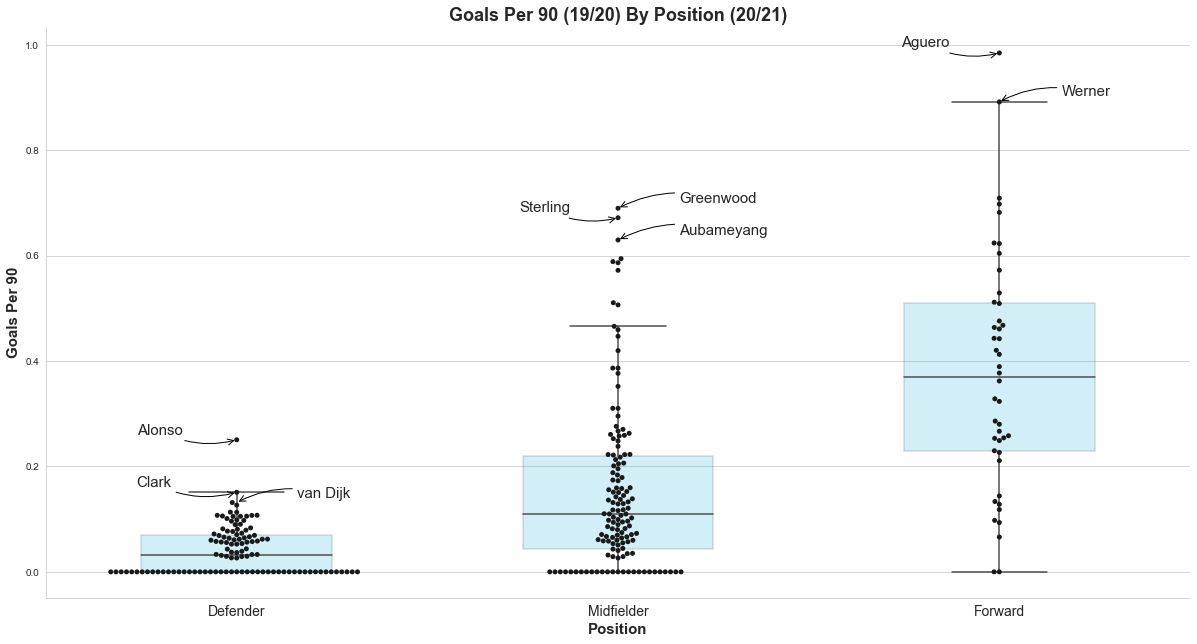

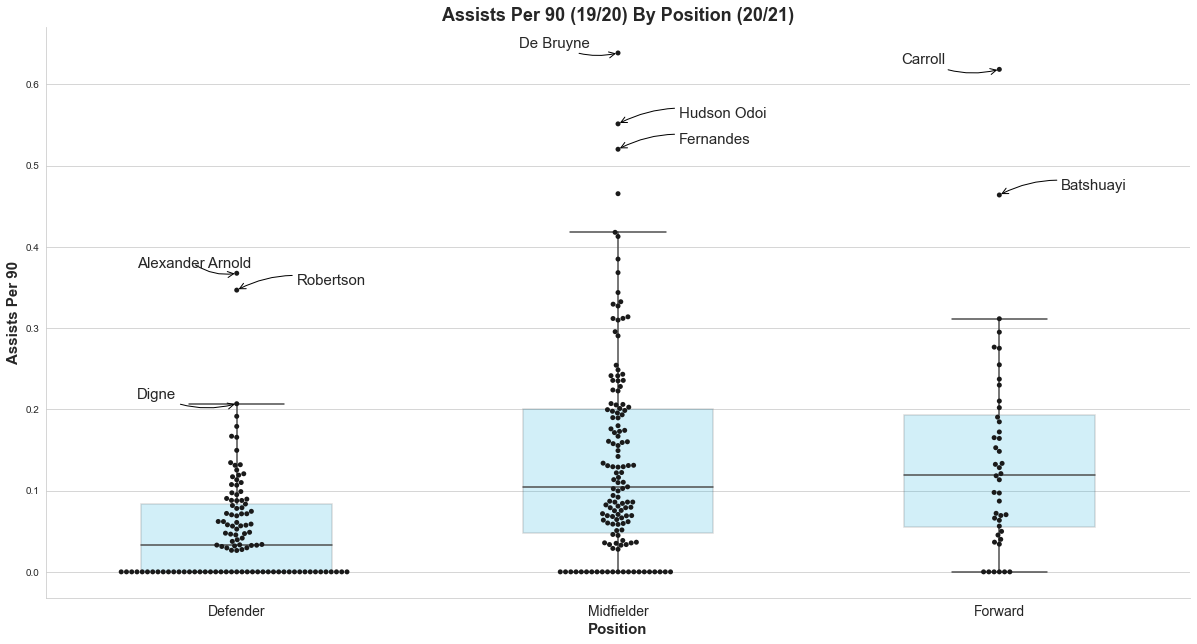

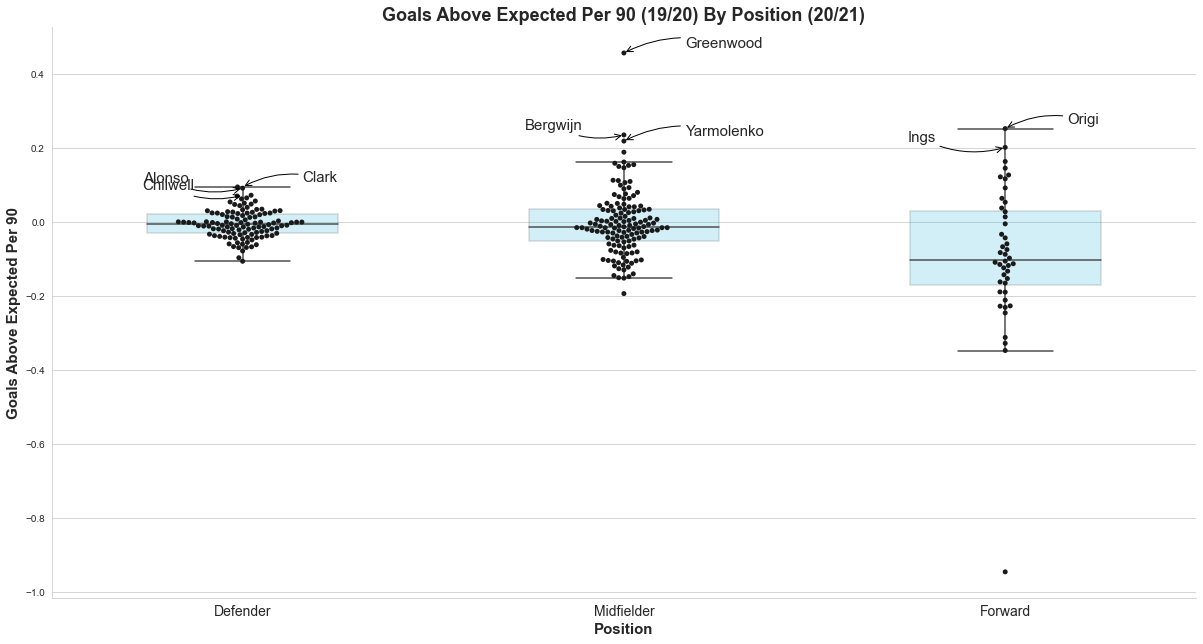

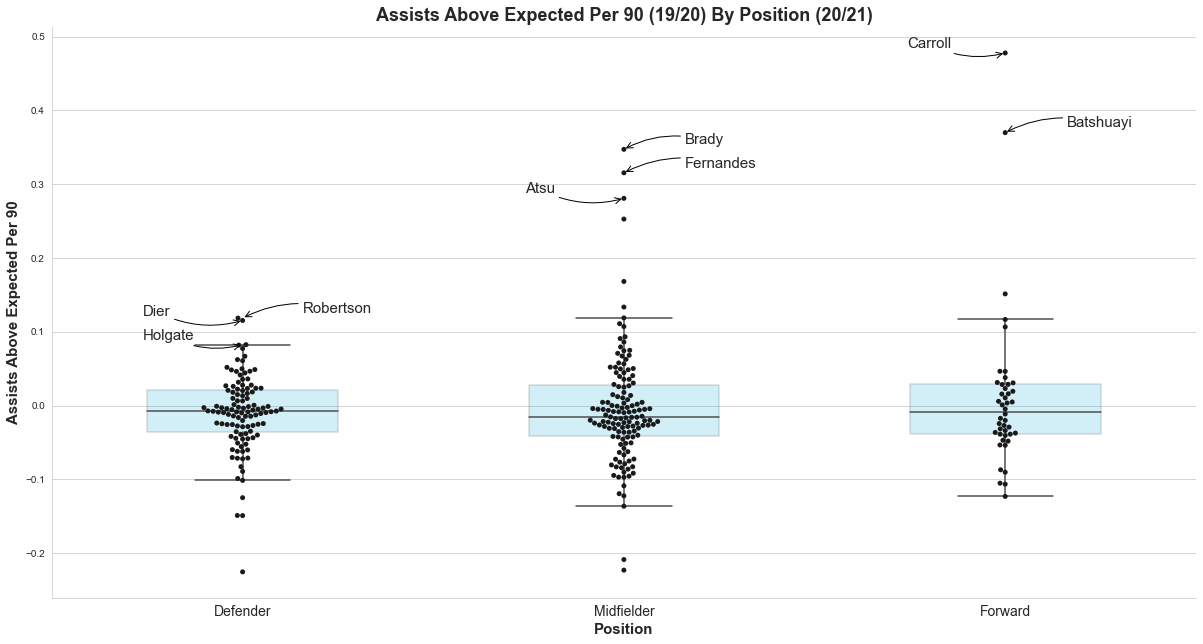

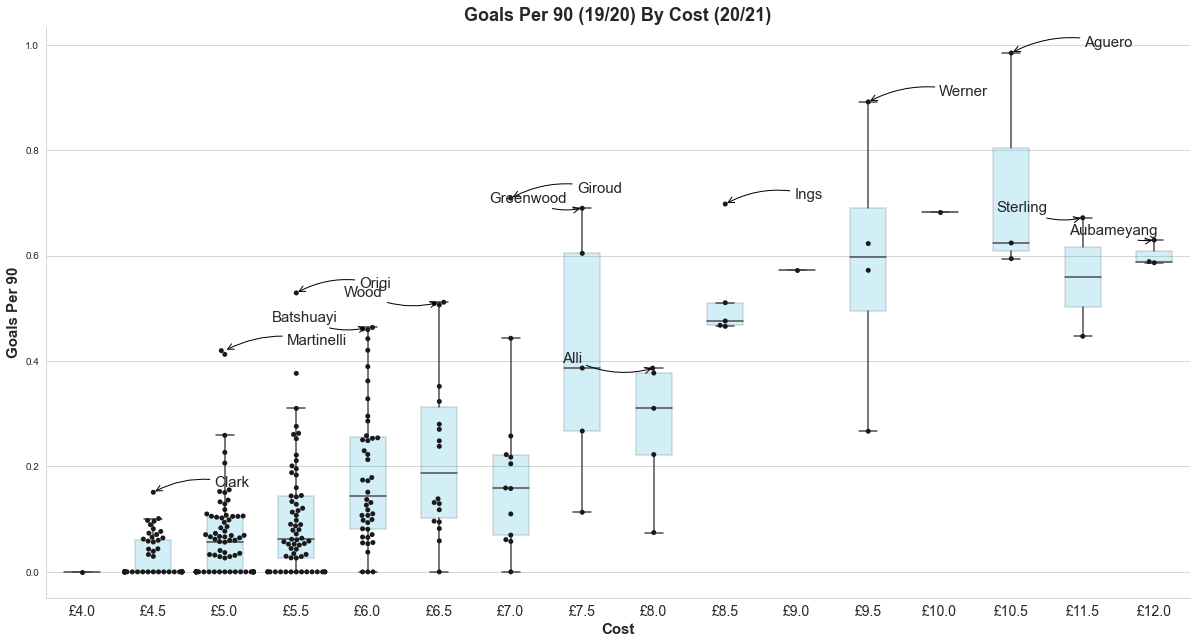

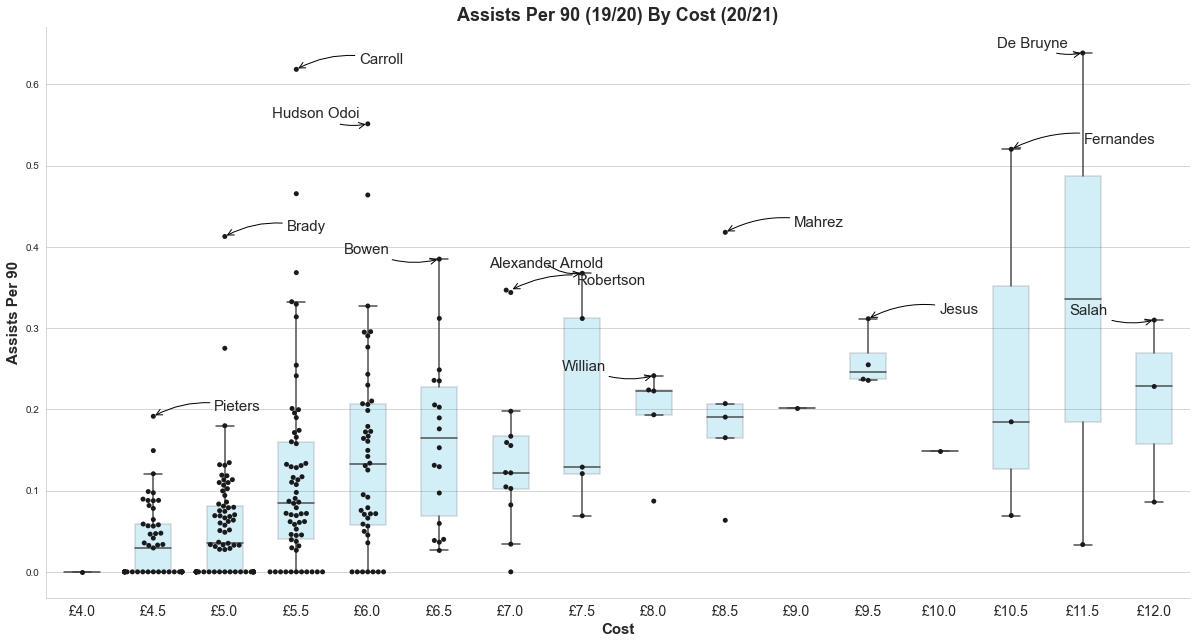

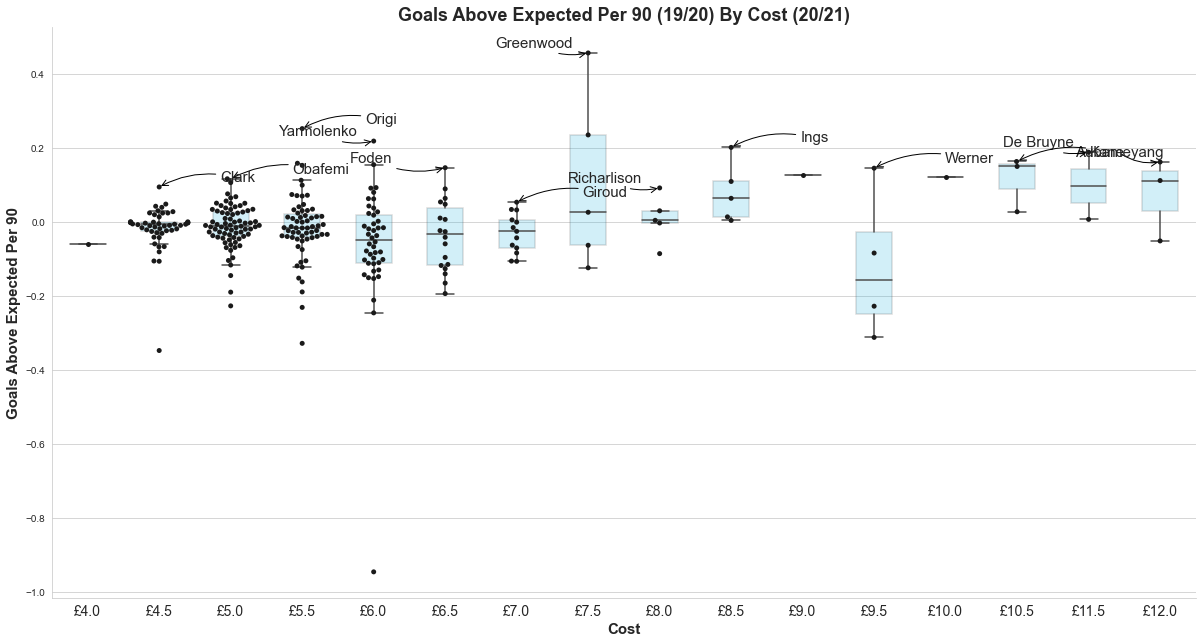

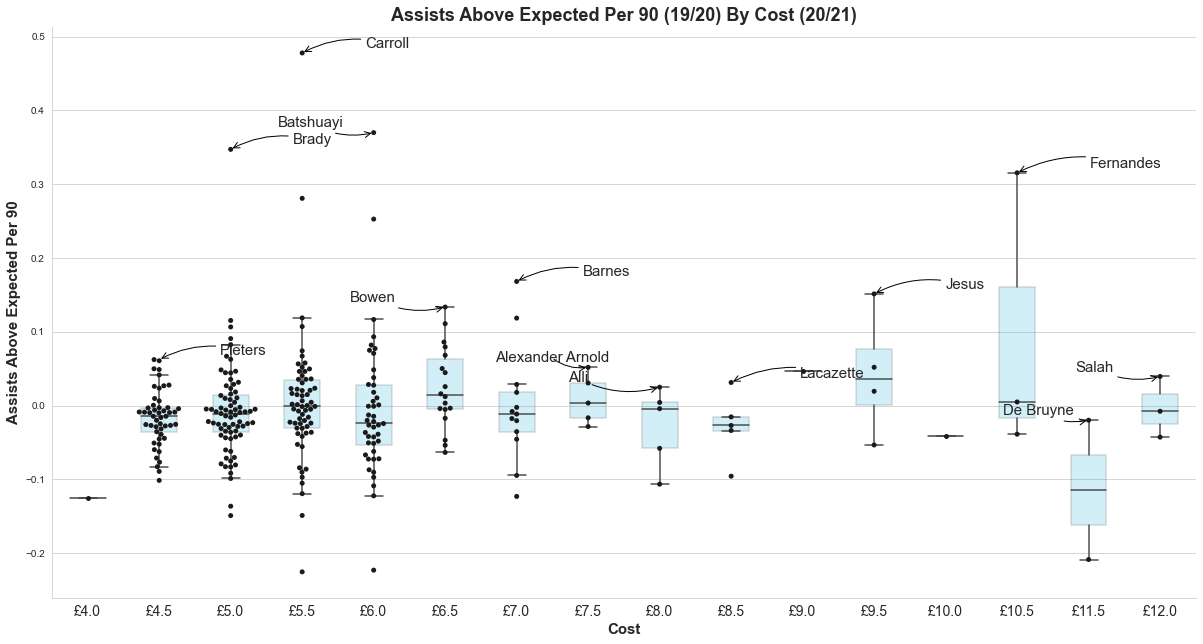

In [6]:
sns.set_style("whitegrid")
groups = ['position', 'cost_string']
metrics = [
    'goals_per_90', 'assists_per_90', 'goals_above_expected_per_90', 'assists_above_expected_per_90'
]

for group in groups:
    for metric in metrics:
        
        ### first prepare the columns we need ###
        
        # set higher quantile threshold if we group by cost to avoid graphs getting messy
        quantile_thresh = 0.97 if group == 'position' else 0.99
        
        metric_pct = main_df.groupby(f"{group}")[f"{metric}"].quantile(quantile_thresh).reset_index()
        metric_pct.columns = [f"{group}", f"{metric}_pct_threshold"]

        main_df = main_df.merge(metric_pct, on=group)
        
        # player rank
        main_df['player_rank_over_metric'] = main_df.groupby(f"{group}")[f"{metric}"].rank(ascending=False)
        
        main_df["annotate"] = False
        main_df.loc[
            (main_df[f"{metric}"] > main_df[f"{metric}_pct_threshold"])
            & (main_df['player_rank_over_metric'] <= 3), 'annotate'
        ] = True
        
        ### THEN PLOT ###
        fig, ax = plt.subplots()
        fig.set_size_inches(20.5, 10.5)

        if group == 'position':
            order = ['Defender', 'Midfielder', 'Forward']
        else:
            order = list(main_df.sort_values(by='now_cost')['cost_string'].drop_duplicates())

        # plot our boxplot and
        ax = sns.boxplot(
            x=group, y=metric, data=main_df, color='deepskyblue', 
            width=0.5, showfliers=False, order=order, boxprops=dict(alpha=.2)
        )
        ax = sns.swarmplot(x=group, y=metric, data=main_df, color=".1", order=order)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # set and format titles
        ax.set_title(f"{metric.replace('_', ' ').title()} (19/20) By {group.split('_')[0].title()} (20/21)", fontdict={'fontsize':18, 'fontweight':'bold'})
        ax.set_xlabel(f"{group.split('_')[0].title()}", fontdict={'fontsize':15, 'fontweight':'bold'})
        ax.set_ylabel(f"{metric.replace('_', ' ').title()}", fontdict={'fontsize':15, 'fontweight':'bold'})
        ax.set_xticklabels(ax.get_xticklabels(), size=14)

        # annotate anything above 95th percentile
        points_to_annotate = main_df.loc[main_df['annotate']==True]

        # we will use i to have annotations coming from left or right of point so it doesn't get too cluttered
        i = 0
        for index, row in points_to_annotate.iterrows():
            x_loc = order.index(row[group])
            # if i is even lets stagger to left, else right
            if i%2 == 0:
                x_text = x_loc + 60
            else:
                x_text = x_loc - 100
            y_loc = row[metric]
            y_text = y_loc + 5

            # annotate
            ax.annotate(row['web_name'],
                    xy=(x_loc, y_loc), xycoords='data', size=15,
                    xytext=(x_text, y_text), textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3,rad=.2",
                                    color='black'))
            i+=1
        plt.savefig(f"images/{metric}_by_{group}", transparent=True)
        
        
        ### FINALLY DROP THE COLUMNS SO WE CAN MAKE THEM AGAIN FOR NEW METRICS ###
        main_df = main_df.drop(columns = ['player_rank_over_metric', f"{metric}_pct_threshold"])